## SMS Spam

#### Class = สถานะข้อความ (สแปมหรือไม่สแปม)
#### message = ข้อความ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import NMF , SparsePCA , PCA , TruncatedSVD

In [3]:
sms = pd.read_csv('spam.csv')
sms = sms[['v1','v2']]
sms.columns = ['class' , 'message']
sms.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
sms['class'] = sms['class'].map(lambda x : 'not spam' if x == 'ham' else x)

In [5]:
plt.style.use('ggplot')

## EDA

#### จำนวนข้อความ แบ่งตาม class

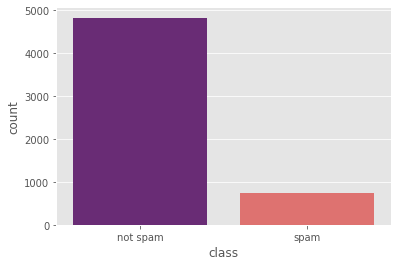

In [6]:
sns.countplot(data=sms , x='class' , palette='magma');

In [7]:
sms['message_len'] = sms['message'].map(lambda x : len(x))

In [8]:
sms

,class,message,message_len
0,not spam,"Go until jurong point, crazy.. Available only ...",111
1,not spam,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,not spam,U dun say so early hor... U c already then say...,49
4,not spam,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,not spam,Will �_ b going to esplanade fr home?,37
5569,not spam,"Pity, * was in mood for that. So...any other s...",57
5570,not spam,The guy did some bitching but I acted like i'd...,125


#### จำนวนตัวอักษรของข้อความ แบ่งตาม class

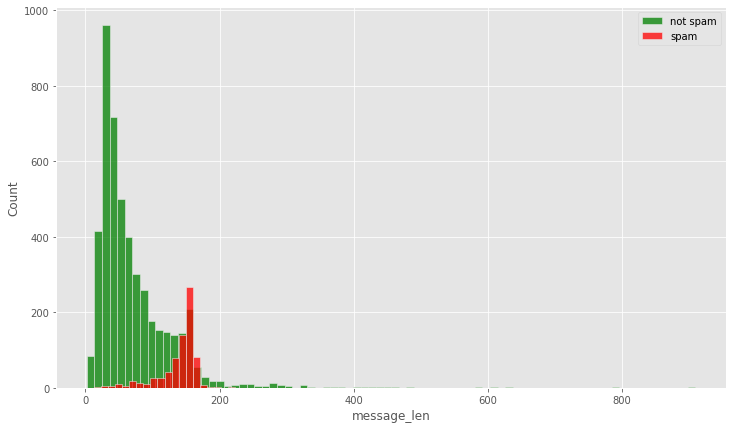

In [9]:
plt.figure(figsize=(12,7))
sns.histplot(sms[sms['class'] == 'not spam']['message_len'] ,bins=80 , label='not spam' , color='green')
sns.histplot(sms[sms['class'] == 'spam']['message_len'] ,bins=20 , label='spam' , color='red')
plt.legend()

#### stopwords : คำสิ้นเปลือง

In [10]:
stopwords.words('english')[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

#### string.punctuation : อักขระ

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### ทำความสะอาดข้อความโดยตัด stopwords และอักขระออกจากข้อความ

In [12]:
def text_clean(message):
    
    clean = [c for c in message if c not in string.punctuation]
    clean = ''.join(clean)
    
    clean = [word for word in clean.split() if word.lower() not in stopwords.words('english')]
    clean = ' '.join(clean)
    
    return clean

#### ก่อนทำความสะอาด

In [13]:
sms['message'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

#### หลังทำความสะอาด

In [14]:
text_clean(sms['message'][10])

'Im gonna home soon dont want talk stuff anymore tonight k Ive cried enough today'

In [15]:
sms['message_clean'] = sms['message'].map(text_clean)

#### message_clean : ข้อความหลังจากทำความสะอาดแล้ว

In [16]:
sms.head()

,class,message,message_len,message_clean
0,not spam,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...
1,not spam,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry 2 wkly comp win FA Cup final tkts 2...
3,not spam,U dun say so early hor... U c already then say...,49,U dun say early hor U c already say
4,not spam,"Nah I don't think he goes to usf, he lives aro...",61,Nah dont think goes usf lives around though


In [17]:
not_spam = sms[sms['class'] == 'not spam']['message_clean']
spam = sms[sms['class'] == 'spam']['message_clean']

In [18]:
spam[2]

'Free entry 2 wkly comp win FA Cup final tkts 21st May 2005 Text FA 87121 receive entry questionstd txt rateTCs apply 08452810075over18s'

In [19]:
spam[2].lower().split()

['free',
 'entry',
 '2',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 'fa',
 '87121',
 'receive',
 'entry',
 'questionstd',
 'txt',
 'ratetcs',
 'apply',
 '08452810075over18s']

In [20]:
not_spam_count = not_spam.map(lambda x : [word.lower() for word in x.split()])
spam_count = spam.map(lambda x : [word.lower() for word in x.split()])

In [21]:
spam_count.head()

2     [free, entry, 2, wkly, comp, win, fa, cup, fin...
5     [freemsg, hey, darling, 3, weeks, word, back, ...
8     [winner, valued, network, customer, selected, ...
9     [mobile, 11, months, u, r, entitled, update, l...
11    [six, chances, win, cash, 100, 20000, pounds, ...
Name: message_clean, dtype: object

#### การนับคำว่าคำไหนปรากฏมากที่สุดในแต่ละ class

In [22]:
count = Counter()
for i in not_spam_count:
    count.update(i)
not_spam_most20 = count.most_common(20)

In [23]:
count = Counter()
for i in spam_count:
    count.update(i)
spam_most20 = count.most_common(20)

In [24]:
not_spam_most20 = pd.DataFrame(not_spam_most20 , columns=['text' , 'count'])
spam_most20 = pd.DataFrame(spam_most20 , columns=['text' , 'count'])

In [25]:
spam_most20.nlargest(10 , 'count')

,text,count
0,call,347
1,free,216
2,2,173
3,txt,150
4,u,147
5,ur,144
6,mobile,123
7,text,120
8,4,119
9,claim,113


#### 20 อันดับ คำที่ปรากฏมากที่สุดของข้อความที่ไม่เป็น spam

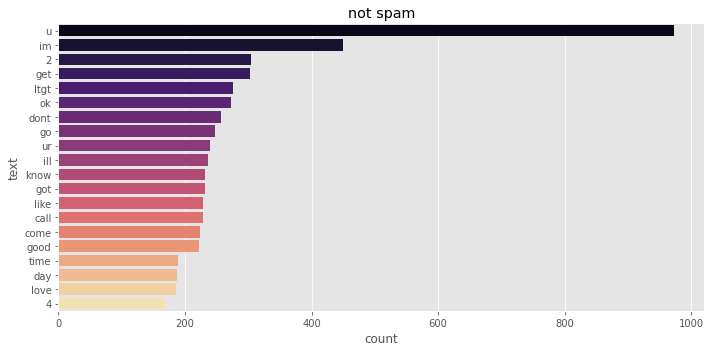

In [26]:
plt.figure(figsize=(10,5))
sns.barplot(data=not_spam_most20 , y='text' , x='count' , palette='magma')
plt.title('not spam')
plt.tight_layout()

#### 20 อันดับคำที่ปรากฏมากที่สุดของข้อความที่เป็น spam

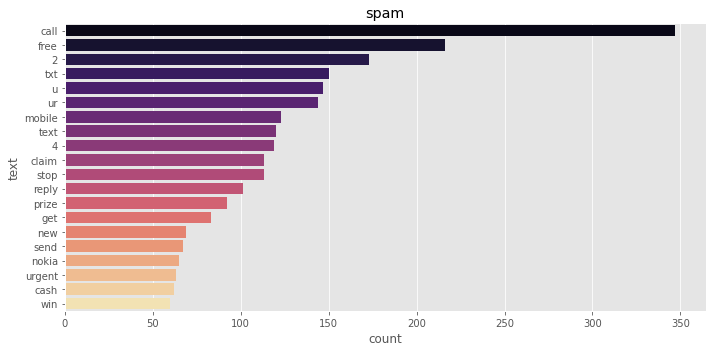

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(data=spam_most20 , y='text' , x='count', palette='magma')
plt.title('spam')
plt.tight_layout()

## Modeling

#### feature preparation

In [28]:
features = sms['message_clean']
target = sms['class']

In [29]:
features.head()

0    Go jurong point crazy Available bugis n great ...
1                              Ok lar Joking wif u oni
2    Free entry 2 wkly comp win FA Cup final tkts 2...
3                  U dun say early hor U c already say
4          Nah dont think goes usf lives around though
Name: message_clean, dtype: object

In [30]:
target.head()

0    not spam
1    not spam
2        spam
3    not spam
4    not spam
Name: class, dtype: object

#### Not Spam = 0 , Spam = 1

In [31]:
target = target.map(lambda x : 0 if x == 'not spam' else 1)

In [32]:
target.values[:10]

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1], dtype=int64)

#### แบ่งข้อมูลออกเป็น 3 ชุด ชุดฝึก ชุดตรวจสอบ ชุดทดสอบ

In [33]:
x_train , x_val , y_train , y_val = train_test_split(features , target , train_size=0.7 , stratify=target , random_state=50)

In [34]:
x_val , x_test , y_val , y_test = train_test_split(x_val , y_val , train_size=0.5 , stratify=y_val , random_state=50)

In [35]:
print(x_train.shape)

(3900,)


In [36]:
print(x_val.shape)

(836,)


In [37]:
print(x_test.shape)

(836,)


#### จำนวน not spam กับ spam ต่างกันเยอะมาก ต้องใช้การ oversampling เข้ามาช่วย

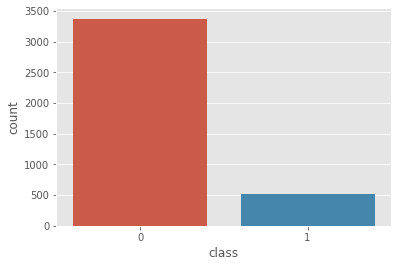

In [38]:
sns.countplot(y_train);

#### ใช้ TfidfVectorizer เพื่อนับความถี่ของคำในแต่ละข้อความ

In [39]:
tfid = TfidfVectorizer(stop_words='english')

#### ใช้ SMOTE เพื่อทำการ oversampling data ให้ class ทั้ง 2 มีค่าเท่ากัน

In [40]:
smote = SMOTE()

In [41]:
x_train_sample = tfid.fit_transform(x_train)
x_test_sample = tfid.transform(x_test)

In [42]:
x_train_sample.shape

(3900, 7424)

In [43]:
x_test_sample.shape

(836, 7424)

In [44]:
x_train_sample , y_train_sample = smote.fit_resample(x_train_sample , y_train)

#### หลังจาก oversampling แล้ว class ทั้ง 2 เท่ากัน

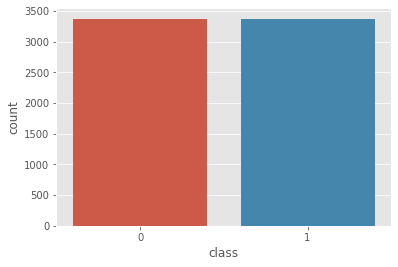

In [45]:
sns.countplot(y_train_sample);

In [46]:
def model_selection(algor):
    pipe = Pipeline([
    ('vectorizer' , tfid) , 
    ('oversampling' , smote) , 
    ('model' , algor)
    ])
    
    pipe.fit(x_train , y_train)
    y_pred = pipe.predict(x_val)
    cof_mat = confusion_matrix(y_pred , y_val)
    sns.heatmap(cof_mat, annot=True , fmt='.0f' , cmap='Oranges' , cbar=False)
    plt.title(algor)
    plt.xlabel('Prediction')
    plt.ylabel('Actuality')
    plt.show()
    print(classification_report(y_pred , y_val))
    print('-'*100)

In [47]:
model_lis = [LogisticRegression() , MultinomialNB() , RandomForestClassifier() , KNeighborsClassifier()]

#### ทำการทดสอบ model เบื้องต้นด้วย algorithm 4 แบบ

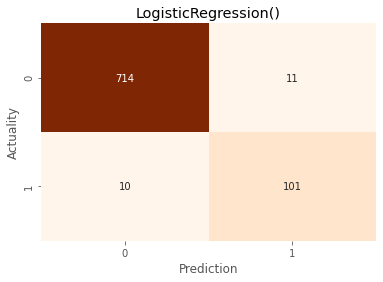

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       725
           1       0.90      0.91      0.91       111

    accuracy                           0.97       836
   macro avg       0.94      0.95      0.95       836
weighted avg       0.97      0.97      0.97       836

----------------------------------------------------------------------------------------------------


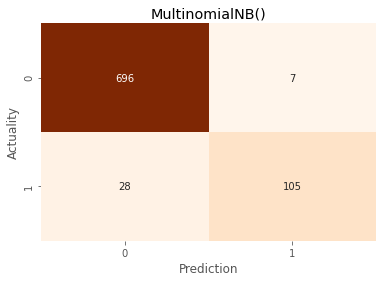

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       703
           1       0.94      0.79      0.86       133

    accuracy                           0.96       836
   macro avg       0.95      0.89      0.92       836
weighted avg       0.96      0.96      0.96       836

----------------------------------------------------------------------------------------------------


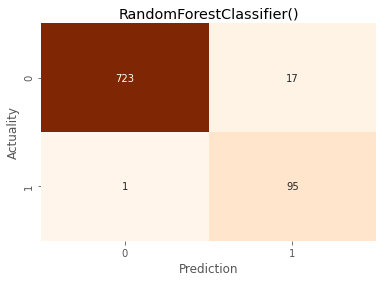

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       740
           1       0.85      0.99      0.91        96

    accuracy                           0.98       836
   macro avg       0.92      0.98      0.95       836
weighted avg       0.98      0.98      0.98       836

----------------------------------------------------------------------------------------------------


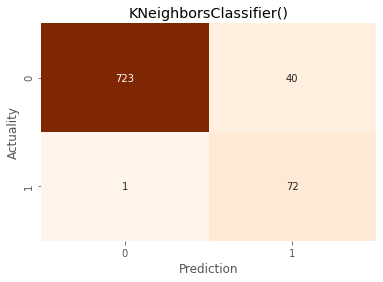

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       763
           1       0.64      0.99      0.78        73

    accuracy                           0.95       836
   macro avg       0.82      0.97      0.88       836
weighted avg       0.97      0.95      0.96       836

----------------------------------------------------------------------------------------------------


In [48]:
for model in model_lis :
    model_selection(model)

#### จากการทดสอบเบื้องต้น Logistic Regression ให้ผลลัพธ์ดีที่สุด

### Logistic Regression

In [49]:
lr = LogisticRegression(n_jobs=-1 , max_iter=1000)

#### นำ TfidfVectorizer , oversampling , model เข้าไปใน pipeline

In [50]:
pipe_lr = Pipeline([
    ('vectorizer' , tfid) , 
    ('oversampling' , smote) , 
    ('model' , lr)
])

#### ใช้ GridSearchCV หา parameter ที่เหมาะสมที่สุด

In [51]:
grid_lr = GridSearchCV(pipe_lr , param_grid=dict(model__penalty = ['l1', 'l2'] , 
                                                model__C=np.logspace(-4, 4, 10) , 
                                                ) , cv = 5 , n_jobs=-1 , verbose=3)

In [52]:
grid_lr.fit(x_train , y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('oversampling', SMOTE()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'model__penalty': ['l1', 'l2']},
             verbose=3)

In [53]:
print(grid_lr.best_params_)

{'model__C': 166.81005372000558, 'model__penalty': 'l2'}


In [54]:
print(grid_lr.best_score_)

0.9825641025641026


In [55]:
best_model = grid_lr.best_estimator_

In [56]:
predict = best_model.predict(x_test)
predict_proba = best_model.predict_proba(x_test)

## Model Evaluation

In [57]:
print(classification_report(y_test , predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       724
           1       0.96      0.88      0.92       112

    accuracy                           0.98       836
   macro avg       0.97      0.93      0.95       836
weighted avg       0.98      0.98      0.98       836



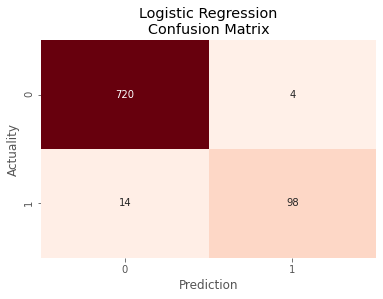

In [58]:
sns.heatmap(confusion_matrix(y_test , predict), annot=True , fmt='.0f' , cmap='Reds' , cbar=False , center=350)
plt.title('Logistic Regression\nConfusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actuality');

In [59]:
tpr , fpr , ths = roc_curve(y_test , predict_proba[:,1])

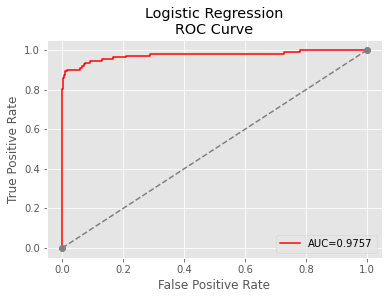

In [60]:
plt.plot(tpr , fpr , label=f'AUC={roc_auc_score(y_test , predict_proba[:,1]).round(4)}' , color='Red')
plt.plot([0,1] , [0,1] , 'o--' , color='0.5')
plt.title('Logistic Regression\nROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

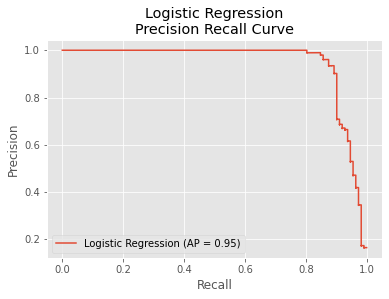

In [61]:
plot_precision_recall_curve(best_model , x_test , y_test , name='Logistic Regression')
plt.title('Logistic Regression\nPrecision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision');

In [62]:
x_train_sample.shape

(6754, 7424)

#### จากข้อมูลชุดฝึก พบว่ามี feature 7424 ซึ่งเยอะมาก ลองทำการจำนวน feature ลงเหลือ 50

In [63]:
pipe_decom = Pipeline([
    ('vectorizer' , tfid) , 
    ('oversampling' , smote) ,
    ('decompos' , TruncatedSVD(n_components=50)),
    ('model' , lr)
])

In [65]:
pipe_decom.fit(x_train , y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('oversampling', SMOTE()),
                ('decompos', TruncatedSVD(n_components=50)),
                ('model', LogisticRegression(max_iter=1000, n_jobs=-1))])

In [66]:
decom_pred = pipe_decom.predict(x_test)
decom_pred_proba = pipe_decom.predict_proba(x_test)

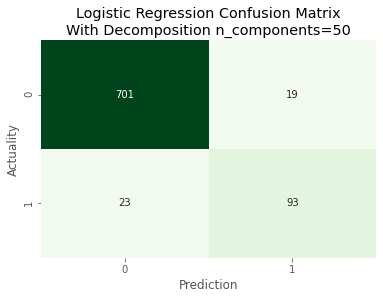

In [67]:
sns.heatmap(confusion_matrix(decom_pred , y_test), annot=True , fmt='.0f' , cmap='Greens' , cbar=False , center=350)
plt.title('Logistic Regression Confusion Matrix\nWith Decomposition n_components=50')
plt.xlabel('Prediction')
plt.ylabel('Actuality');

In [68]:
print(classification_report(decom_pred , y_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       720
           1       0.83      0.80      0.82       116

    accuracy                           0.95       836
   macro avg       0.90      0.89      0.89       836
weighted avg       0.95      0.95      0.95       836



#### การลดมิติข้อมูลจาก 7424 features เหลือ 50 features พบว่าความแม่นยำลดลงเล็กน้อย 
#### แต่เราสามารถลด features ลงไป 148 เท่า !!!